In [12]:
import pandas as pd
import os

# 設定檔案路徑 (因為你在 notebooks 裡面，所以要用 ../ 回到上一層找 data)
human_path = '../data/human.csv'
ai_path = '../data/ai.csv'

# 1. 讀取雙檔案
try:
    df_human = pd.read_csv(human_path)
    df_ai = pd.read_csv(ai_path)
    
    # 2. 手動標記標籤 (0=人類, 1=AI)
    df_human['label'] = 0
    df_ai['label'] = 1
    
    # 3. 合併資料集
    df = pd.concat([df_human, df_ai], axis=0).reset_index(drop=True)
    
    print(f"✅ 成功載入！人類樣本: {len(df_human)} 筆, AI 樣本: {len(df_ai)} 筆")
    print(f"總筆數: {len(df)}")
except FileNotFoundError as e:
    print(f"❌ 找不到檔案，請檢查路徑：{e}")

# 4. 觀察資料欄位 (假設內容欄位叫 'text')
print("\n--- 資料前五筆 ---")
display(df.head())

✅ 成功載入！人類樣本: 198932 筆, AI 樣本: 198931 筆
總筆數: 397863

--- 資料前五筆 ---


,source,id,text,label
0,human,813221,My grandfather was a loving man. We were all s...,0
1,human,813222,C-Span had unprecedented viewers. Everyone was...,0
2,human,813223,"King Erik and his wife, Dalia, watched the clo...",0
3,human,813224,The chaotic noise of the market place always b...,0
4,human,813225,Oh come on these little fucktards worship us....,0


In [13]:
# 檢查是否有 NaN 
print(df.isnull().sum())

# 如果有任何 text 是空的，直接移除
df = df.dropna(subset=['text'])

# 檢查一下文字長度，避免有那種只有 1 個字的無效資料
df = df[df['text'].str.len() > 10]
print(f"清洗後剩餘筆數: {len(df)}")

source      0
id          0
text      160
label       0
dtype: int64
清洗後剩餘筆數: 397393


In [14]:
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm # 用於顯示進度條

# 1. 下載 NLTK 停用詞庫
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 2. 定義清理函數
def clean_text(text):
    # 轉小寫
    text = str(text).lower()
    # 移除特殊符號與標點 (只保留英文字母)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # 移除多餘空白
    text = re.sub(r'\s+', ' ', text).strip()
    # 移除停用詞
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

# 3. 執行清理 (使用 tqdm 顯示 40 萬筆的進度)
tqdm.pandas() # 啟動 pandas 進度條功能
print("正在執行深度文字清理 (大約需要 2-5 分鐘)...")
df['text'] = df['text'].progress_apply(clean_text)

# 4. 再次檢查是否因清理產生空值 (例如有些內容全是標點符號)
df = df[df['text'].str.len() > 0]
print(f"清理完成！最終可用資料量: {len(df)}")
display(df.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


正在執行深度文字清理 (大約需要 2-5 分鐘)...


100%|██████████| 397393/397393 [01:43<00:00, 3835.24it/s] 


清理完成！最終可用資料量: 396626


,source,id,text,label
0,human,813221,grandfather loving man sad see go near end war...,0
1,human,813222,cspan unprecedented viewers everyone curious m...,0
2,human,813223,king erik wife dalia watched cloaked figure ma...,0
3,human,813224,chaotic noise market place always bothered joh...,0
4,human,813225,oh come little fucktards worship us really lea...,0


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import joblib
import os

# 1. 切分資料 (80% 訓練, 20% 測試)
# stratify=y 確保訓練集與測試集的 AI/Human 比例是一致的
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# 2. 建立進階 TF-IDF 特徵
# ngram_range=(1, 2) 代表同時提取單字 (Unigram) 與 雙單詞 (Bigram)
# min_df=5: 該詞組至少要在 5 篇文章出現過才納入，過濾掉極罕見的雜訊
tfidf = TfidfVectorizer(
    max_features=20000, 
    ngram_range=(1, 2), 
    min_df=5, 
    sublinear_tf=True
)

print("正在建立 TF-IDF 特徵矩陣 (包含 n-gram)...")
X_train = tfidf.fit_transform(X_train_raw)
X_test = tfidf.transform(X_test_raw)

print(f"✅ 特徵建立完成！")
print(f"訓練集形狀: {X_train.shape}")
print(f"測試集形狀: {X_test.shape}")

正在建立 TF-IDF 特徵矩陣 (包含 n-gram)...
✅ 特徵建立完成！
訓練集形狀: (317300, 20000)
測試集形狀: (79326, 20000)


--- [Step 4] 正在訓練 Logistic Regression ---
✅ LR 訓練完成！耗時: 10.89 秒

[Logistic Regression] 績效報告:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     39779
           1       0.98      0.98      0.98     39547

    accuracy                           0.98     79326
   macro avg       0.98      0.98      0.98     79326
weighted avg       0.98      0.98      0.98     79326



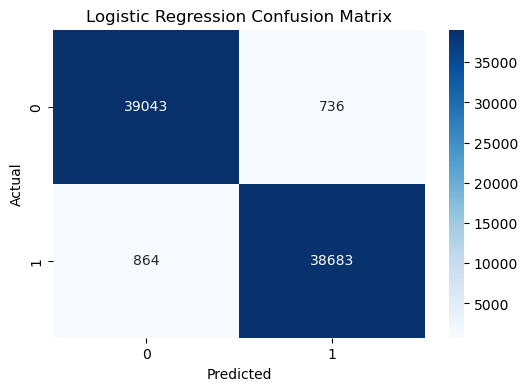

['../models/logistic_regression_v1.pkl']

In [18]:
import time
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("--- [Step 4] 正在訓練 Logistic Regression ---")
start_lr = time.time()

# 建立並訓練 LR 模型
lr_model = LogisticRegression(max_iter=1000, n_jobs=-1)
lr_model.fit(X_train, y_train)

lr_duration = time.time() - start_lr
print(f"✅ LR 訓練完成！耗時: {lr_duration:.2f} 秒")

# 評估 LR
lr_pred = lr_model.predict(X_test)
print("\n[Logistic Regression] 績效報告:")
print(classification_report(y_test, lr_pred))

# 畫出 LR 混淆矩陣
cm_lr = confusion_matrix(y_test, lr_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('../results/logistic_regression_cm.png')
plt.show()

# 儲存 LR 模型
joblib.dump(lr_model, '../models/logistic_regression_v1.pkl')


--- [Step 5] 正在訓練 Random Forest (快速版) ---
✅ RF 訓練完成！耗時: 58.42 秒

[Random Forest] 績效報告:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     39779
           1       0.97      0.96      0.96     39547

    accuracy                           0.96     79326
   macro avg       0.96      0.96      0.96     79326
weighted avg       0.96      0.96      0.96     79326



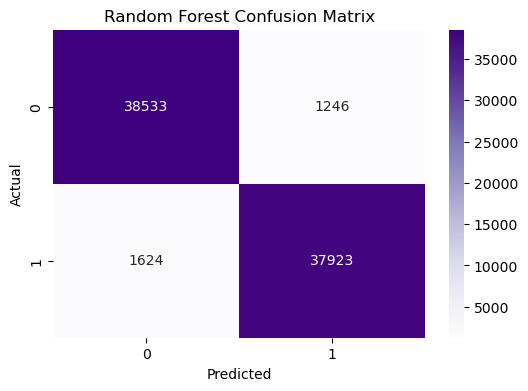


✅ 所有模型與特徵工具已儲存完成！


In [19]:
print("\n--- [Step 5] 正在訓練 Random Forest (快速版) ---")
start_rf = time.time()

# 建立並訓練 RF 模型 (限制深度與樹的數量)
rf_model = RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)

rf_duration = time.time() - start_rf
print(f"✅ RF 訓練完成！耗時: {rf_duration:.2f} 秒")

# 評估 RF
rf_pred = rf_model.predict(X_test)
print("\n[Random Forest] 績效報告:")
print(classification_report(y_test, rf_pred))

# 畫出 RF 混淆矩陣
cm_rf = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Purples')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('../results/random_forest_cm.png')
plt.show()

# 儲存 RF 模型與 TF-IDF (TF-IDF 只要存一次即可)
joblib.dump(rf_model, '../models/random_forest_v1.pkl')
joblib.dump(tfidf, '../models/tfidf_vectorizer.pkl')
print("\n✅ 所有模型與特徵工具已儲存完成！")

--- 🔍 偵測結果分析 ---

[AI 寫作特徵詞 Top 20]:
             Word     Weight
19           also  13.909035
18         cannot  10.531301
17      including   7.972365
16    even though   7.284113
15          gonna   7.081172
14      according   6.806151
13            lot   6.729217
12        example   6.716962
11        article   6.647812
10      important   6.424138
9          season   6.286672
8         chapter   6.174931
7            able   6.145685
6   advertisement   6.107816
5      would like   5.629319
4         episode   5.487210
3            help   5.446953
2          series   5.438510
1             use   5.302550
0         yearold   5.297096

[人類寫作特徵詞 Top 20]:
          Word    Weight
0          sir -8.756604
1         shit -8.678107
2       prompt -8.005481
3        every -7.054305
4         hell -6.885388
5         damn -6.758193
6       course -6.110074
7         eyes -6.078188
8       almost -6.056877
9         yeah -6.041420
10        fuck -6.036910
11     fucking -5.734082
12      th

C:\Users\USER\AppData\Local\Temp\ipykernel_12708\833054700.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Word', data=ai_features.sort_values(by='Weight', ascending=False), palette='magma')


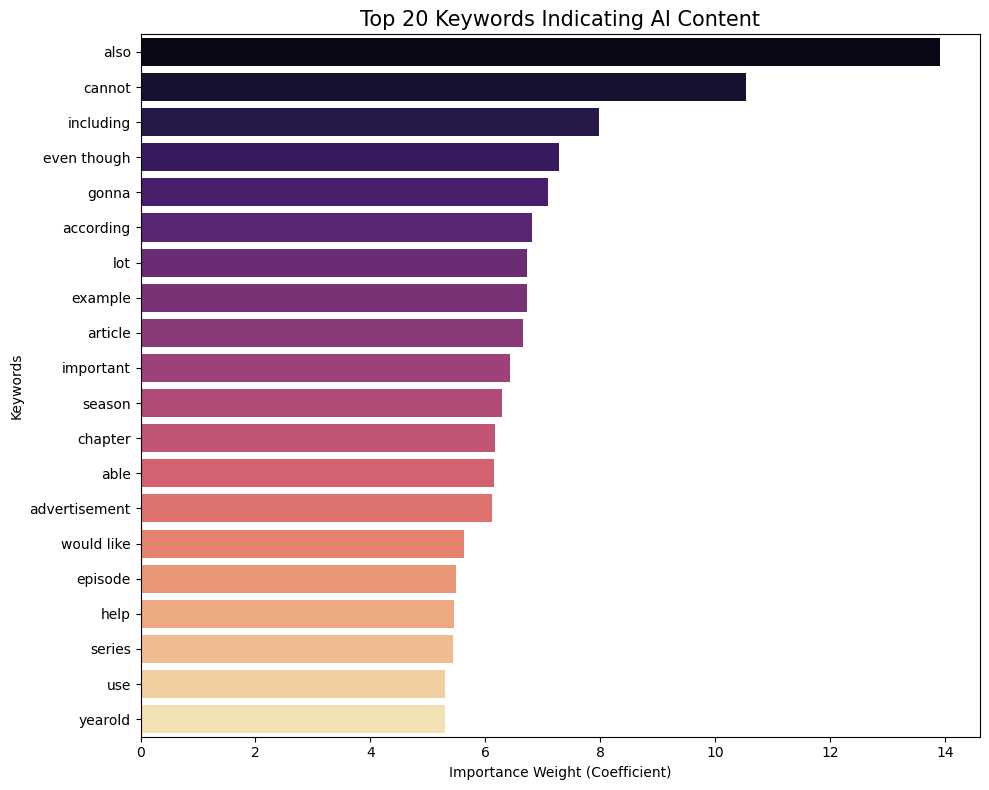

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 取得 TF-IDF 的所有詞彙 (特徵名稱)
feature_names = np.array(tfidf.get_feature_names_out())

# 2. 取得 Logistic Regression 的係數 (權重)
# 權重愈正，代表該詞愈指向 AI (Label 1)；權重愈負，代表該詞愈指向人類 (Label 0)
coefs = lr_model.coef_[0]

# 3. 找出最強的 20 個 AI 特徵詞與人類特徵詞
top_ai_indices = np.argsort(coefs)[-20:]
top_human_indices = np.argsort(coefs)[:20]

# 4. 整理成 DataFrame 方便觀察與繪圖
ai_features = pd.DataFrame({'Word': feature_names[top_ai_indices], 'Weight': coefs[top_ai_indices]})
human_features = pd.DataFrame({'Word': feature_names[top_human_indices], 'Weight': coefs[top_human_indices]})

print("--- 🔍 偵測結果分析 ---")
print("\n[AI 寫作特徵詞 Top 20]:")
print(ai_features.sort_values(by='Weight', ascending=False))

print("\n[人類寫作特徵詞 Top 20]:")
print(human_features.sort_values(by='Weight', ascending=True))

# 5. 視覺化：畫出 AI 特徵詞的權重圖 (這張圖必放報告！)
plt.figure(figsize=(10, 8))
sns.barplot(x='Weight', y='Word', data=ai_features.sort_values(by='Weight', ascending=False), palette='magma')
plt.title('Top 20 Keywords Indicating AI Content', fontsize=15)
plt.xlabel('Importance Weight (Coefficient)')
plt.ylabel('Keywords')
plt.tight_layout()

# 儲存圖表到 results
plt.savefig('../results/top_ai_keywords.png')
plt.show()